# seqFISH Mouse Organogenesis

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>)
- **Date of Creation:** 22.01.2023
- **Date of Last Modification:** 16.12.2024

- In order to run this notebook, a trained model needs to be stored under f"../artifacts/{dataset}/models/{model_label}/{load_timestamp}".

## 1. Setup

### 1.1 Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../../utils")

In [ ]:
import argparse
import gc
import os
import random
import shutil
import warnings
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import scipy.stats as stats
import seaborn as sns
import squidpy as sq
import torch
from matplotlib import gridspec
from matplotlib.pyplot import rc_context
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from pywaffle import Waffle
from sklearn.metrics import silhouette_score
from matplotlib_venn import venn2

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                aggregate_obsp_matrix_per_cell_type,
                                create_cell_type_chord_plot_from_df,
                                create_new_color_dict,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                generate_enriched_gp_info_plots)

from analysis_utils import (add_cell_type_latent_cluster_emphasis,
                            add_sub_cell_type,
                            compute_cell_type_latent_clusters,
                            generate_gp_info_plots,
                            plot_physical_latent_for_cell_types,
                            plot_cell_type_latent_clusters,
                            plot_latent,
                            plot_category_in_latent_and_physical_space,
                            sankey,
                            store_top_gps_summary)

### 1.2 Define Parameters

In [ ]:
dataset = "seqfish_mouse_organogenesis_imputed"

#### 1.2.1 Generic Parameters

In [ ]:
## Model
# AnnData keys
adj_key = "spatial_connectivities"
spatial_key = "spatial"
sub_cell_type_key = "sub_cell_type"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
latent_key = "nichecompass_latent"
mapping_entity_key = "mapping_entity"

## Analysis
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

## Others
random_seed = 0

#### 1.2.2 Dataset-specific Parameters

In [ ]:
multimodal = False
log_norm_omics_features = False
cell_type_groups = []
latent_groups = []

load_timestamp = "09082023_225056_10"
model_label = "reference"
counts_key = "log_normalized_counts"
cell_type_key = "celltype_mapped_refined"
dataset_str = "seqFISH Mouse Organogenesis Imputed"
multimodal = False
sample_key = "sample"
condition_key = "batch"
latent_leiden_resolution = 0.35
latent_groups = ["16", "15", "4", "10", "5", "6"]
spot_size = 0.05
cell_type_groups = []
multimodal = False
samples = ["embryo2"]
    
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"

### 1.3 Run Notebook Setup

In [ ]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [ ]:
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 5

### 1.4 Configure Paths and Create Directories

In [ ]:
# Define paths
figure_folder_path = f"../../artifacts/{dataset}/figures/{model_label}/{load_timestamp}"
model_folder_path = f"../../artifacts/{dataset}/models/{model_label}/{load_timestamp}"
result_folder_path = f"../../artifacts/{dataset}/results/{model_label}/{load_timestamp}"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
ga_data_folder_path = "../../datasets/ga_data"
srt_data_folder_path = "../../datasets/st_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(result_folder_path, exist_ok=True)

## 2. Model

### 2.1 Load Model

In [ ]:
if model_label == "sample_integration_method_benchmarking":
    model_folder_path = f"{model_folder_path}/run{run_number}"

In [ ]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name=f"{dataset}_{model_label}.h5ad",
                          gp_names_key=gp_names_key)

In [ ]:
model.adata.uns[gp_names_key] = np.array([gp for gp in model.adata.uns[gp_names_key] if not "Add-on " in gp])
model.adata.uns[active_gp_names_key] = np.array([gp for gp in model.adata.uns[active_gp_names_key] if not "Add-on " in gp])
model.adata.uns[gp_names_key] = np.array([gp.replace(" ", "_") for gp in model.adata.uns[gp_names_key]])
model.adata.uns[active_gp_names_key] = np.array([gp.replace(" ", "_") for gp in model.adata.uns[active_gp_names_key]])

## 3. Analysis

In [ ]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

In [ ]:
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True][20:]

### 3.1 Analyze Latent Manifold

In [ ]:
samples = model.adata.obs[sample_key].unique().tolist()
model.add_active_gp_scores_to_obs()

In [ ]:
if mapping_entity_key in model.adata.obs:
    if model.adata.obs[mapping_entity_key].nunique() > 1:
        # Plot mapping entities in latent and physical space
        mapping_entity_colors = create_new_color_dict(
            adata=model.adata,
            cat_key=mapping_entity_key)

        save_fig = True
        file_path = f"{figure_folder_path}/" \
                    "mapping_entities_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label="Mapping Entities",
            cat_key=mapping_entity_key,
            groups=None,
            sample_key=sample_key,
            samples=samples,
            cat_colors=mapping_entity_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path)

In [ ]:
# Plot batches in latent and physical space
condition_colors = create_new_color_dict(
    adata=model.adata,
    color_palette="batch",
    cat_key=condition_key)

save_fig = True
file_path = f"{figure_folder_path}/" \
            "batches_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Batches",
    cat_key=condition_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=condition_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [ ]:
# Plot cell types in latent and physical space
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    color_palette=("cell_type_20" if dataset == "xenium_human_breast_cancer" else "cell_type_30"),
    cat_key=cell_type_key)

if dataset in ["spatial_atac_rna_seq_mouse_brain_batch2", "spatial_atac_rna_seq_mouse_brain_batch2_rna_only"]:
    cell_type_colors["CA3GL"] = "#1f77b4"
    cell_type_colors["D1MSN"] = "#ff7f0e"
    cell_type_colors["LSXGA"] = "#279e68"
    cell_type_colors["MXD"] = "#d62728"
    cell_type_colors["STRGA"] = "#aa40fc"

save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Cell Types",
    cat_key=cell_type_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=cell_type_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [ ]:
if len(cell_type_groups) > 0:
    # Plot cell type groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(cell_type_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [ ]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    color_palette="default",
    cat_key=latent_cluster_key)

In [ ]:
save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "latent_clusters_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Niches",
    cat_key=latent_cluster_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=latent_cluster_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [ ]:
gp_resign = True

mapping_entity_colors = {"reference": "#D3D3D3"}

save_fig = True
file_path = f"{figure_folder_path}/" \
            "mapping_entities_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Mapping Entities",
    cat_key=mapping_entity_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=mapping_entity_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)



In [ ]:
niche_annotation_dict = {
    "0": "Saa1/Il6st+ Muscles",
    "1": "Bmp8a/9-cis-Ret. acid+ Splanch. Mesoderm",
    "2": "IL10/Fgf2+ Vasculature (Angiogenesis)",
    "3": "Nptn/Fgf8+ Spinal Cord",
    "4": "Ihh/Spint1+ Ventral Gut",
    "5": "Pcsk1n/Dkk1+ Forebrain",
    "6": "Fgf17/Efna2+ Midbrain",
    "7": "Tgfbi/Fgf6+ Cranial Mesoderm",
    "8": "Guanine/Slitrk1+ Neural Crest (Neural Tube)",
    "9": "Sfrp4/Pdgfa+ Surface Ectoderm",
    "10": "Gdf10/Fgf3+ Hindbrain",
    "11": "Edn1/Nppa1+ Developing Heart",
    "12": "Epo/Thpo+ Vasculature (Hematopoiesis)",
    "13": "Bmp4/Vegfb+ Lateral Plate Mesoderm",
    "14": "Cdh13/Col1a1+ Mixed Mesench. Mesoderm",
    "15": "Calca/Shh+ Floor Plate",
    "16": "Cthrc1/Pdgfc+ Dorsal Gut",
    "17": "Fgf18/Dll1+ Presomitic Mesoderm",
    "18": "Pgf/Cd44+ Allantois",
    "19": "Mix"
}

model.adata.obs["niche"] = model.adata.obs[f"latent_leiden_{latent_leiden_resolution}"].map(niche_annotation_dict)
niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}

save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Niches",
    cat_key="niche",
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=niche_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [ ]:
    sc.tl.dendrogram(adata=model.adata,
                     use_rep="nichecompass_latent",
                     linkage_method="single",
                     groupby="niche")

    fig, (ax) = plt.subplots(1, 1, figsize=(0.6, 2))
    sc.pl.dendrogram(
        adata=model.adata,
        groupby="niche",
        orientation="left",
        ax=ax,
        save="dendrogram_nichecompass_latent.svg")
    plt.show()

In [ ]:
model.adata.obs["niche_abr"] = model.adata.obs["niche"].apply(lambda x: x.split("GP+ ")[1].replace(" ", "\n") if "GP+ " in x else x)

niche_abreviated_colors = {}

for key, value in niche_colors.items():
    if "GP+ " in key:
        niche_abreviated_colors[key.split("+ ")[1].replace(" ", "\n")] = value
    else:
        niche_abreviated_colors[key] = value

In [ ]:
# Fig. 2c: Niche data source composition
tmp = pd.crosstab(model.adata.obs["niche"],model.adata.obs['batch'], normalize='index')
tmp = tmp.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::])
tmp.index = [gp_name.split("+ ")[1].replace("Mesenchymal", "Mesench.") if "+" in gp_name else gp_name for gp_name in tmp.index.tolist()]
ax = tmp.plot.barh(color=condition_colors, stacked=True, figsize=(2, 6)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Data Source Proportions")
plt.xticks([0.1, 0.5, 1.0])
plt.savefig(f"{figure_folder_path}/niche_batch_proportions.svg", bbox_inches='tight')

In [ ]:
# Fig. 2g: Niche cell type composition
tmp = pd.crosstab(model.adata.obs["niche"], model.adata.obs[cell_type_key], normalize='index')
tmp = tmp.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::])
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(4, 6)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Cell Type Proportions")
plt.xticks([0.1, 0.5, 1.0])
plt.savefig(f"{figure_folder_path}/niche_cell_type_proportions.svg", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sankey(
    x=model.adata.obs[cell_type_key],
    y=model.adata.obs["niche"],
    title="Cell Type to Niche Mapping",
    title_left="Cell Type Label",
    title_right="Niche Label",
    ax=ax,
    fontsize="5",  # "xx-small",
    #left_order=["Mixed mesenchymal mesoderm", "Lateral plate mesoderm", "Intermediate mesoderm", "Allantois", "Splanchnic mesoderm",
    #            "ExE endoderm", "Cardiomyocytes", "Definitive endoderm", "Gut tube", "Surface ectoderm", "Neural crest", "Cranial mesoderm",
    #            "Erythroid", "Blood progenitors", "Endothelium", "Haematoendothelial progenitors", "Forebrain/Midbrain/Hindbrain",
    #            "Spinal cord", "NMP", "Dermomyotome", "Sclerotome", "Anterior somitic tissues", "Presomitic mesoderm"],
    colors=cell_type_colors,
    alpha=0.5,
)
plt.savefig(f"{figure_folder_path}/sankey_cell_type_to_niche.svg")
plt.show()

In [ ]:
# Adjust signs of GPs
gps = [
        "Cdh13_ligand_receptor_target_gene_GP", "Col1a1_ligand_receptor_target_gene_GP",        
        "BMP4_ligand_receptor_GP", "Vegfb_ligand_receptor_target_gene_GP",  
        "Pgf_ligand_receptor_target_gene_GP", "Cd44_ligand_receptor_target_gene_GP",
        "Bmp8a_ligand_receptor_target_gene_GP", "9-cis-Retinoic_acid_metabolite_enzyme_sensor_GP",
        "Edn1_ligand_receptor_target_gene_GP", "NPPA_ligand_receptor_GP",
        "Cthrc1_ligand_receptor_target_gene_GP", "PDGFC_ligand_receptor_GP",
        "IHH_ligand_receptor_GP", "Spint1_ligand_receptor_target_gene_GP",
        "SFRP4_ligand_receptor_GP", "PDGFA_ligand_receptor_GP",
        "Guanine_metabolite_enzyme_sensor_GP", "Slitrk1_ligand_receptor_target_gene_GP",
        "Tgfbi_ligand_receptor_target_gene_GP", "FGF6_ligand_receptor_GP",
        "Epo_ligand_receptor_target_gene_GP", "Thpo_ligand_receptor_target_gene_GP",
        "Il10_ligand_receptor_target_gene_GP", "Fgf2_ligand_receptor_target_gene_GP",
        "Fgf17_ligand_receptor_target_gene_GP", "Efna2_ligand_receptor_target_gene_GP",
        "PCSK1N_ligand_receptor_GP", "DKK1_ligand_receptor_GP",
        "Calca_ligand_receptor_target_gene_GP", "Shh_ligand_receptor_target_gene_GP",
        "Gdf10_ligand_receptor_target_gene_GP", "Fgf3_ligand_receptor_target_gene_GP",
        "NPTN_ligand_receptor_GP", "Fgf8_ligand_receptor_target_gene_GP",
        "SAA1_ligand_receptor_GP", "IL6ST_ligand_receptor_GP",
        "Fgf18_ligand_receptor_target_gene_GP", "Dll1_ligand_receptor_target_gene_GP",    
    ]
    
resign_gps = [
    "IL6ST_ligand_receptor_GP",
    "9-cis-Retinoic_acid_metabolite_enzyme_sensor_GP",
    "Il10_ligand_receptor_target_gene_GP",
    "Fgf8_ligand_receptor_target_gene_GP",
    "Oleic_acid_metabolite_enzyme_sensor_GP",
    "L-Threonine_metabolite_enzyme_sensor_GP",
    "Efna2_ligand_receptor_target_gene_GP",
    "Slitrk1_ligand_receptor_target_gene_GP",
    "Fgf3_ligand_receptor_target_gene_GP",
    "NPPA_ligand_receptor_GP",
    "Thpo_ligand_receptor_target_gene_GP",
    "Calca_ligand_receptor_target_gene_GP",
    "PDGFC_ligand_receptor_GP",
    "Dll1_ligand_receptor_target_gene_GP",
    "Cthrc1_ligand_receptor_target_gene_GP",
    "Bmp8a_ligand_receptor_target_gene_GP",
    "Spint1_ligand_receptor_target_gene_GP",
    "FGF6_ligand_receptor_GP",
    "SFRP4_ligand_receptor_GP",
    "VCAM1_ligand_receptor_GP",
]

if gp_resign:
    for gp in resign_gps:
        model.adata.obs[gp] = -1 * model.adata.obs[gp]

In [ ]:
# Fig. 2f: GP heatmap
df = model.adata.obs[["niche"] + gps].groupby("niche").mean()
df = df.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::-1])

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index
normalized_df.columns = [col.split("_lig")[0].split("_met")[0].replace("_", " ").replace("9-cis-Retinoic", "9-cis-Ret.").capitalize() + " GP" for col in normalized_df.columns]

plt.figure(figsize=(16, 6))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           ha="right"
          )
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
            bbox_inches="tight")

plt.figure(figsize=(6, 3))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0,
            cbar_kws={"orientation": "horizontal", "location": "bottom", "shrink": 0.4})
plt.xticks([])
plt.savefig(f"{figure_folder_path}/heatmap_colorbar.svg",
            bbox_inches="tight")

In [ ]:
sc.tl.dendrogram(adata=model.adata,
                     var_names=gps,
                     linkage_method="single",
                     groupby="niche")

fig, (ax) = plt.subplots(1, 1, figsize=(3, 8))
sc.pl.dendrogram(
    adata=model.adata,
    groupby="niche",
    orientation="left",
    ax=ax)
plt.show()

In [ ]:
# Fig. 2i: Niches in tissue
save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "forebrain_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Niches",
    cat_key="niche",
    groups=["Pcsk1n/Dkk1+ Forebrain"],
    sample_key=sample_key,
    samples=samples,
    cat_colors=niche_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "midbrain_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Niches",
    cat_key="niche",
    groups=["Fgf17/Efna2+ Midbrain"],
    sample_key=sample_key,
    samples=samples,
    cat_colors=niche_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "hindbrain_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Niches",
    cat_key="niche",
    groups=["Gdf10/Fgf3+ Hindbrain"],
    sample_key=sample_key,
    samples=samples,
    cat_colors=niche_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "floorplate_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Niches",
    cat_key="niche",
    groups=["Calca/Shh+ Floor Plate"],
    sample_key=sample_key,
    samples=samples,
    cat_colors=niche_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [ ]:
color_map = "RdGy_r"
fig, axs = plt.subplots(nrows=4,
                        ncols=2,
                        figsize=(15, 15))
# Forebrain
sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color="PCSK1N_ligand_receptor_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Pcsk1n GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color="DKK1_ligand_receptor_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Dkk1 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Midbrain
sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color="Fgf17_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fgf17 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color="Efna2_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Efna2 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

# Floor plate
sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color="Calca_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Calca GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color="Shh_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Shh GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)

# Hindbrain
sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color="Gdf10_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gdf10 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color="Fgf3_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fgf3 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/brain_enriched_gps.svg",
            bbox_inches="tight")

In [ ]:
# Fig. 5i,k: GPs enriched in brain niches 
adata_top = model.adata[model.adata.obsm["spatial"][:,1] < 0]
adata_top = adata_top[adata_top.obs["sample"] == "embryo2"]

for gp in gps:
    scaler = MinMaxScaler()
    # Fit and transform the column to normalize its values
    adata_top.obs[f'{gp}_normalized'] = scaler.fit_transform(adata_top.obs[[gp]])

fig, axs = plt.subplots(nrows=4,
                        ncols=2,
                        figsize=(15, 15))

# Forebrain
sc.pl.spatial(
    adata=adata_top,
    color="PCSK1N_ligand_receptor_GP_normalized",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Pcsk1n GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="DKK1_ligand_receptor_GP_normalized",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Dkk1 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Midbrain
sc.pl.spatial(
    adata=adata_top,
    color="Fgf17_ligand_receptor_target_gene_GP_normalized",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fgf17 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Efna2_ligand_receptor_target_gene_GP_normalized",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Efna2 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

# Floor plate
sc.pl.spatial(
    adata=adata_top,
    color="Calca_ligand_receptor_target_gene_GP_normalized",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Calca GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Shh_ligand_receptor_target_gene_GP_normalized",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Shh GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)

# Hindbrain
sc.pl.spatial(
    adata=adata_top,
    color="Gdf10_ligand_receptor_target_gene_GP_normalized",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gdf10 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Fgf3_ligand_receptor_target_gene_GP_normalized",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fgf3 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/brain_enriched_gps_top.svg",
            bbox_inches="tight")

In [ ]:
# Fig. 5i,k: Gene expression of genes in brain niches GPs
color_map = "RdPu"
fig, axs = plt.subplots(nrows=5,
                        ncols=2,
                        figsize=(15, 15))

# Forebrain
sc.pl.spatial(
    adata=adata_top,
    color="Pcsk1n",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Pcsk1n",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Dkk1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Dkk1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Midbrain
sc.pl.spatial(
    adata=adata_top,
    color="Fgf17",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fgf17",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Fgfr2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fgfr2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Efna2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Efna2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)

# Floor plate
sc.pl.spatial(
    adata=adata_top,
    color="Calca",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Calca",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Shh",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Shh",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)

# Hindbrain
sc.pl.spatial(
    adata=adata_top,
    color="Gdf10",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gdf10",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 1],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Fgf3",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fgf3",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[4, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Fgfr1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fgfr1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[4, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/brain_enriched_gps_genes.svg",
            bbox_inches="tight")

In [ ]:
# Fig. 2k: Shh GP gene expression
color_map = "RdPu"
fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))

# Ligand
sc.pl.spatial(
    adata=adata_top,
    color="Shh",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Shh",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)

# Receptor
sc.pl.spatial(
    adata=adata_top,
    color="Ptch1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ptch1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Top 5 target genes
sc.pl.spatial(
    adata=adata_top,
    color="Nkx2-9",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nkx2-9",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Foxf2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Foxf2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Slit2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Slit2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Mnx1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mnx1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Foxd1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Foxd1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/shh_ligand_receptor_target_gene_gp.svg",
            bbox_inches="tight")

In [ ]:
value_mapping = {"5": "Forebrain",
                 "6": "Midbrain",
                 "10": "Hindbrain",
                 "15": "Floor Plate"}
category_colors = {'Forebrain': latent_cluster_colors["5"],
                   'Midbrain': latent_cluster_colors["6"],
                   'Hindbrain': latent_cluster_colors["10"],
                   'Floor Plate': latent_cluster_colors["15"]}

def map_values(value):
    if value in value_mapping:
        return value_mapping[value]
    else:
        return np.nan

model.adata.obs['Brain Niches'] = model.adata.obs['latent_leiden_0.35'].apply(map_values)

with sns.axes_style("ticks"):
    # Floor Plate (Tegmentum)
    ax = sns.scatterplot(x='Shh_ligand_receptor_target_gene_GP', # Pixna1_ligand_receptor_target_gene_GP
                    y='Calca_ligand_receptor_target_gene_GP',
                    hue='Brain Niches',
                    data=model.adata.obs,
                    palette=category_colors)
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Shh GP")
    plt.ylabel("Calca GP")
    plt.savefig(f"{figure_folder_path}/floorplate_scatterplot.svg", bbox_inches="tight", bbox_extra_artists=[lgd])

In [ ]:
# Fig. 5h: Gut niches
save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "dorsalgut_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Niches",
    cat_key="niche",
    groups=["Cthrc1/Pdgfc+ Dorsal Gut"],
    sample_key=sample_key,
    samples=samples,
    cat_colors=niche_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

# Ventral Gut
save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "ventralgut_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Niches",
    cat_key="niche",
    groups=["Ihh/Spint1+ Ventral Gut"],
    sample_key=sample_key,
    samples=samples,
    cat_colors=niche_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [ ]:
# Fig. 2h: GPs enriched in gut niches
adata_gut = model.adata[model.adata.obsm["spatial"][:,1] < 2.8]
adata_gut = adata_gut[adata_gut.obsm["spatial"][:,1] > -1.6]
adata_gut = adata_gut[adata_gut.obsm["spatial"][:,0] < 1.3]
adata_gut = adata_gut[adata_gut.obsm["spatial"][:,0] > -1.2]
adata_gut = adata_gut[adata_gut.obs["sample"] == "embryo2"]

for gp in gps:
    scaler = MinMaxScaler()
    # Fit and transform the column to normalize its values
    adata_gut.obs[f'{gp}_normalized'] = scaler.fit_transform(adata_gut.obs[[gp]])

color_map = "RdGy_r"
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        figsize=(15, 15))

# Ventral Gut
sc.pl.spatial(
    adata=adata_gut,
    color="IHH_ligand_receptor_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ihh GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Spint1_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Spint1 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Dorsal Gut
sc.pl.spatial(
    adata=adata_gut,
    color="Cthrc1_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cthrc1 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="PDGFC_ligand_receptor_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Pdgfc GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)
plt.show()
fig.savefig(f"{figure_folder_path}/gut_enriched_gps.svg",
            bbox_inches="tight")

In [ ]:
# Fig. 5j: Gene expression of genes in gut niches GPs
color_map = "RdPu"
fig, axs = plt.subplots(nrows=4,
                        ncols=2,
                        figsize=(15, 15))

# Ventral Gut
sc.pl.spatial(
    adata=adata_gut,
    color="Ihh",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ihh",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Smo",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Smo",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Spint1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Spint1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="St14",
    color_map=color_map,
    spot_size=spot_size,
    title=f"St14",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

# Dorsal Gut
sc.pl.spatial(
    adata=adata_gut,
    color="Cthrc1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cthrc1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Fzd3",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fzd3",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Pdgfc",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Pdgfc",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 1],
    show=False)
plt.show()
fig.savefig(f"{figure_folder_path}/gut_enriched_gps_genes.svg",
            bbox_inches="tight")

In [ ]:
# Fig. 2j: Spint1 GP gene expression
color_map = "RdPu"
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        figsize=(15, 15))

# Ligand
sc.pl.spatial(
    adata=adata_gut,
    color="Spint1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Spint1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)

# Receptor
sc.pl.spatial(
    adata=adata_gut,
    color="St14",
    color_map=color_map,
    spot_size=spot_size,
    title=f"St14",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Dorsal Gut
sc.pl.spatial(
    adata=adata_gut,
    color="Mmp14",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mmp14",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Fstl1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fstl1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)
plt.show()
fig.savefig(f"{figure_folder_path}/spint1_ligand_receptor_target_gene_gp.svg",
            bbox_inches="tight")

In [ ]:
model.model.features_idx_dict_["target_reconstructed_rna_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["target_masked_rna_idx"], model.model.features_idx_dict_["target_unmasked_rna_idx"])))
model.model.features_idx_dict_["source_reconstructed_rna_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["source_masked_rna_idx"], model.model.features_idx_dict_["source_unmasked_rna_idx"])))

output = model.get_omics_decoder_outputs(
                adata=model.adata,
                only_active_gps=True,
                node_batch_size=2048)

for gene in ["Spint1", "Ihh", "Cthrc1", "Pdgfc"]:
    model.adata.obs[f"{gene}_rec"] = output["source_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]


for gene in ["St14", "Smo", "Fzd3"]:
    model.adata.obs[f"{gene}_rec"] = output["target_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]    

In [ ]:
adata_gut = model.adata[model.adata.obsm["spatial"][:,1] < 2.8]
adata_gut = adata_gut[adata_gut.obsm["spatial"][:,1] > -1.6]
adata_gut = adata_gut[adata_gut.obsm["spatial"][:,0] < 1.3]
adata_gut = adata_gut[adata_gut.obsm["spatial"][:,0] > -1.2]
adata_gut = adata_gut[adata_gut.obs["sample"] == "embryo2"]

adata_gut.obs["Vtn_ligand_receptor_target_gene_GP"] = -1 *  adata_gut.obs["Vtn_ligand_receptor_target_gene_GP"] 

# Reconstructed gene expression
color_map = "RdPu"
fig, axs = plt.subplots(nrows=4,
                        ncols=2,
                        figsize=(15, 15))
# Ventral Gut
sc.pl.spatial(
    adata=adata_gut,
    color="Spint1_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Spint1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="St14_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"St14",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Ihh_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ihh",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Smo_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Smo",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

# Dorsal Gut
sc.pl.spatial(
    adata=adata_gut,
    color="Cthrc1_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cthrc1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Fzd3_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fzd3",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)    
sc.pl.spatial(
    adata=adata_gut,
    color="Pdgfc_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Pdgfc",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)
plt.show()
fig.savefig(f"{figure_folder_path}/gut_enriched_gps_reconstructed_genes.svg",
            bbox_inches="tight")

In [ ]:
color_map = "RdPu"
fig, axs = plt.subplots(nrows=4,
                        ncols=2,
                        figsize=(25, 15))

# Ligand
sc.pl.spatial(
    adata=adata_gut,
    color="Vtn",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Vtn",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)

# Receptor
sc.pl.spatial(
    adata=adata_gut,
    color="Itga2b",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Itga2b",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Itga5",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Itga5",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)    

# Target Genes
sc.pl.spatial(
    adata=adata_gut,
    color="Pxdn",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Pxdn",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Mecom",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mecom",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Kdr",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Kdr",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)
sc.pl.spatial(
    adata=adata_gut,
    color="Crem",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Crem",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)

# GP
color_map = "RdGy_r"
sc.pl.spatial(
adata=adata_gut,
color="Vtn_ligand_receptor_target_gene_GP",
color_map=color_map,
spot_size=spot_size,
title=f"Vtn GP",
legend_loc=None,
colorbar_loc="bottom",
ax=axs[3, 1],
show=False)
plt.show()
fig.savefig(f"{figure_folder_path}/vtn_ligand_receptor_target_gene_gp.svg",
            bbox_inches="tight")

In [ ]:
for gene in ["Pcsk1n", "Dkk1", "Fgf17", "Efna2", "Calca", "Shh", "Gdf10", "Fgf3"]:
    model.adata.obs[f"{gene}_rec"] = output["source_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]

for gene in ["Fgfr2", "Ptch1", "Fgfr1"]:
    model.adata.obs[f"{gene}_rec"] = output["target_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]

adata_top = model.adata[model.adata.obsm["spatial"][:,1] < 0]
adata_top = adata_top[adata_top.obs["sample"] == "embryo2"]

# Reconstructed gene expression
color_map = "RdPu"
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                        figsize=(15, 15))
# Forebrain
sc.pl.spatial(
    adata=adata_top,
    color="Pcsk1n_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Pcsk1n",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Dkk1_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Dkk1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Midbrain
sc.pl.spatial(
    adata=adata_top,
    color="Fgf17_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fgf17",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Fgfr2_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fgfr2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Efna2_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Efna2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)

# Floor plate
sc.pl.spatial(
    adata=adata_top,
    color="Calca_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Calca",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Shh_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Shh",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Ptch1_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ptch1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 1],
    show=False)

# Hindbrain
sc.pl.spatial(
    adata=adata_top,
    color="Gdf10_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gdf10",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[4, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Fgf3_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fgf3",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[4, 1],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Fgfr1_rec",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fgfr1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[5, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/brain_enriched_gps_reconstructed_genes.svg",
            bbox_inches="tight")

In [ ]:
color_map = "RdPu"
fig, axs = plt.subplots(nrows=4,
                        ncols=2,
                        figsize=(15, 15))
# Floor Plate markers
sc.pl.spatial(
    adata=adata_top,
    color="Foxa1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Foxa1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Foxa2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Foxa2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=adata_top,
    color="Ntn1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ntn1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/floor_plate_markers.svg",
            bbox_inches="tight")

In [ ]:
for gene in ["Ihh", "Spint1", "Cthrc1", "Pdgfc"]:
            model.adata.obs[f"{gene}_rec"] = output["source_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]

In [ ]:
niche_groups = ["IL10/Fgf2+ Vasculature (Angiogenesis)"]

if len(niche_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/angiogenesis_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(niche_groups)}",
        cat_key="niche",
        groups=niche_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

niche_groups = ["Bmp8a/9-cis-Ret. acid+ Splanch. Mesoderm"]

if len(niche_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/splanchnic_mesoderm_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(niche_groups)}",
        cat_key="niche",
        groups=niche_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
# Fig. 4 j,k: Niche cell-cell communication
network_df = compute_communication_gp_network(
    gp_list=["Shh_ligand_receptor_target_gene_GP", "Vtn_ligand_receptor_target_gene_GP"],
    model=model,
    group_key="niche_abr", # celltype
    n_neighbors=90)

shh_network_df = network_df[network_df["edge_type"] == "Shh_ligand_receptor_target_gene_GP"]
vtn_network_df = network_df[network_df["edge_type"] == "Vtn_ligand_receptor_target_gene_GP"]

visualize_communication_gp_network(
    adata=model.adata,
    network_df=shh_network_df,
    figsize=(12, 7),
    cat_colors=niche_abreviated_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key="niche_abr",
    save=True,
    save_path=f"{figure_folder_path}/gp_network_shh.svg",
    )

visualize_communication_gp_network(
    adata=model.adata,
    network_df=vtn_network_df,
    figsize=(8, 7),
    cat_colors=niche_abreviated_colors,
    edge_type_colors=["#ff7f0e"],
    cat_key="niche_abr",
    save=True,
    save_path=f"{figure_folder_path}/gp_network_vtn.svg",
    )

In [ ]:
  
    
    
    
    
        
    
    
    def return_niche_cell_types(row, niche):
        if row["niche"] == niche:
            return row[cell_type_key]
        else:
            return "-1"

    niche = "Edn1 GP/Nppa1 GP+ Developing Heart"
    model.adata.obs[f"{niche}_{cell_type_key}"] = model.adata.obs.apply(
        lambda row: return_niche_cell_types(row, niche), axis=1)

    spot_size = 0.15

    cell_type_groups = ["Cardiomyocytes"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"{cell_type_groups[0].lower()}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=f"{niche}_{cell_type_key}",
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(1440000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"{niche.split('+ ')[1].lower()}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=niche,
        cat_key="niche",
        groups=[niche],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(1440000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    def return_niche_cell_types(row, niche):
        if row["niche"] == niche:
            return row[cell_type_key]
        else:
            return "-1"

    niche = "IL10 GP/Fgf2 GP+ Vasculature (Angiogenesis)"
    model.adata.obs[f"{niche}_{cell_type_key}"] = model.adata.obs.apply(
        lambda row: return_niche_cell_types(row, niche), axis=1)

    spot_size = 0.15

    cell_type_groups = ["Endothelium"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"{cell_type_groups[0].lower()}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=f"{niche}_{cell_type_key}",
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    spot_size = 0.15

    cell_type_groups = ["Haematoendothelial progenitors"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"{cell_type_groups[0].lower()}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=f"{niche}_{cell_type_key}",
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"{niche.split('+ ')[1].lower()}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=niche,
        cat_key="niche",
        groups=[niche],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    def return_niche_cell_types(row, niches):
        if row["niche"] in niches:
            return row[cell_type_key]
        else:
            return "-1"

    niches = ["Fgf17 GP/Efna2 GP+ Midbrain",
              "Pcsk1n GP/Dkk1 GP+ Forebrain",
              "Calca GP/Shh GP+ Floor Plate",
              "Gdf10 GP/Fgf3 GP+ Hindbrain"]
    model.adata.obs[f"brain_niches_{cell_type_key}"] = model.adata.obs.apply(
        lambda row: return_niche_cell_types(row, niches), axis=1)

    spot_size = 0.15

    cell_type_groups = ["Forebrain/Midbrain/Hindbrain"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"brain_cell_types_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=f"brain_niches_{cell_type_key}",
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"brain_niches_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="",
        cat_key="niche",
        groups=niches,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    def return_niche_cell_types(row, niches):
        if row["niche"] in niches:
            return row[cell_type_key]
        else:
            return "-1"

    niches = ["Ihh GP/Spint1 GP+ Ventral Gut",
              "Cthrc1 GP/Pdgfc GP+ Dorsal Gut"]
    model.adata.obs[f"brain_niches_{cell_type_key}"] = model.adata.obs.apply(
        lambda row: return_niche_cell_types(row, niches), axis=1)

    spot_size = 0.15

    cell_type_groups = ["Gut tube"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"gut_tube_cell_types_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=f"brain_niches_{cell_type_key}",
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"gut_tube_niches_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="",
        cat_key="niche",
        groups=niches,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    spot_size = 0.15

    cell_type_groups = ["Allantois", "Presomitic mesoderm", "Lateral plate mesoderm"]
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(cell_type_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    niches = ["Bmp4 GP/Vegfb GP+ Lateral Plate Mesoderm",
              "Pgf GP/Cd44 GP+ Allantois",
              "Fgf18 GP/Dll1 GP+ Presomitic Mesoderm"]

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"missing_niches_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="",
        cat_key="niche",
        groups=niches,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))

    # Ventral Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Nog",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Nog",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Cthrc1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cthrc1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/notochord_markers.svg",
                bbox_inches="tight")
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))
    # Vtn GP
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Vtn_ligand_receptor_target_gene_GP_source_score",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Vtn GP source score",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Vtn_ligand_receptor_target_gene_GP_target_score",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Vtn GP target score",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    # Shh GP
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Shh_ligand_receptor_target_gene_GP_source_score",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh GP source score",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Shh_ligand_receptor_target_gene_GP_target_score",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh GP target score",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/cci_gp_source_target_scores.svg",
                bbox_inches="tight")
    
    network_df = compute_communication_gp_network(
        gp_list=["Shh_ligand_receptor_target_gene_GP", "Vtn_ligand_receptor_target_gene_GP"],
        model=model,
        group_key=cell_type_key, # celltype
        n_neighbors=90)
        
    shh_network_df = network_df[network_df["edge_type"] == "Shh_ligand_receptor_target_gene_GP"]
    vtn_network_df = network_df[network_df["edge_type"] == "Vtn_ligand_receptor_target_gene_GP"]
    
    visualize_communication_gp_network(
        adata=model.adata,
        network_df=shh_network_df,
        figsize=(10, 8),
        cat_colors=cell_type_colors,
        edge_type_colors=["#1f77b4"], 
        cat_key=cell_type_key,
        save=True,
        save_path=f"{figure_folder_path}/gp_network_shh_cell_types.svg",
        )

    visualize_communication_gp_network(
        adata=model.adata,
        network_df=vtn_network_df,
        figsize=(12, 9),
        cat_colors=cell_type_colors,
        edge_type_colors=["#ff7f0e"],
        cat_key=cell_type_key,
        save=True,
        save_path=f"{figure_folder_path}/gp_network_vtn_cell_types.svg",
        )
    
    cell_type_groups = ["Definitive endoderm"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"definitive_endoderm_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Definitive endoderm",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    cell_type_groups = ["Forebrain/Midbrain/Hindbrain"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"forebrain_midbrain_hindbrain_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Forebrain/Midbrain/Hindbrain",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    cell_type_groups = ["Gut tube"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"gut_tube_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Gut tube",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    cell_type_groups = ["Endothelium"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"endothelium_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Endothelium",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
for latent_cluster in model.adata.obs[latent_cluster_key].unique().tolist():
    # Latent clusters in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                f"latent_cluster_{latent_cluster}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Latent Clusters",
        cat_key=latent_cluster_key,
        groups=latent_cluster,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
if len(latent_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(latent_groups)}",
        cat_key=latent_cluster_key,
        groups=latent_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
model.adata.obs["Spint1"] = np.array(model.adata.X[:, model.adata.var_names.tolist().index("Spint1")].todense()).flatten()
model.adata.obs["St14"] = np.array(model.adata.X[:, model.adata.var_names.tolist().index("St14")].todense()).flatten()

In [ ]:
model.adata.obs["Vtn_source_score"]

In [ ]:
df_grouped = df.groupby("niche_abr").mean()

In [ ]:
    with sns.axes_style("ticks"):
        # Floor Plate (Tegmentum)
        ax = sns.scatterplot(x='Spint1', # Pixna1_ligand_receptor_target_gene_GP
                        y='St14',
                        hue='niche_abr',
                        data=df_grouped,
                        palette=niche_abreviated_colors)
        lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel("Shh GP")
        plt.ylabel("Calca GP")
        #plt.savefig(f"{figure_folder_path}/floorplate_scatterplot.svg", bbox_inches="tight", bbox_extra_artists=[lgd])
 

In [ ]:
model.adata.obs["niche"].unique().tolist()

In [ ]:
model.adata.X.toarray()

In [ ]:
# Supplementary Fig. 37

sc.pp.normalize_total(model.adata, target_sum=1e4)
sc.pp.log1p(model.adata)
# model.adata.raw = model.adata  # freeze the state in `.raw`

In [ ]:
sc.pp.highly_variable_genes(model.adata,subset=False,n_top_genes=2000)

In [ ]:
sc.pp.pca(model.adata)

In [ ]:
sc.pp.neighbors(model.adata,use_rep='X_pca')

In [ ]:
sc.tl.umap(adata)

In [ ]:
resolutions = [0.1,0.15, 0.2,0.25, 0.3,0.35, 0.4,0.45, 0.5,0.55, 0.6,0.65, 0.7,0.75, 0.8,0.85, 0.9,0.95, 1,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9,1.95,2]

silhouette_scores = []

for res in resolutions:
    sc.tl.leiden(model.adata, resolution=res, key_added=f'leiden_{res}')
    
    labels = model.adata.obs[f'leiden_{res}']
    silhouette_avg = silhouette_score(model.adata.obsm['X_pca'], labels, metric='euclidean')
    silhouette_scores.append(silhouette_avg)

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(resolutions)), silhouette_scores, color='skyblue', edgecolor='black')
plt.xticks(range(len(resolutions)), [str(r) for r in resolutions],fontsize=5)
plt.xlabel('Resolution')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Leiden Resolutions')
plt.show()

In [ ]:
sc.tl.leiden(model.adata , resolution=0.6 ,key_added='leiden_0.6')

In [ ]:
# Assuming 'adata' is your AnnData object
# Rank genes for each cluster against all other clusters
sc.tl.rank_genes_groups(model.adata, 'leiden_0.6', method='wilcoxon')

# Set to store the top genes from each cluster
top_genes_set = set()

# Iterate over each cluster to get the top 20 significant genes
for cluster in model.adata.obs['leiden_0.6'].cat.categories:
    # Extract the result for the current cluster
    cluster_genes = model.adata.uns['rank_genes_groups']['names'][cluster]
    cluster_pvals_adj = model.adata.uns['rank_genes_groups']['pvals_adj'][cluster]
    cluster_logfoldchanges = model.adata.uns['rank_genes_groups']['logfoldchanges'][cluster]

    # Combine the gene names, p-values, and log fold changes into a DataFrame
    cluster_df = pd.DataFrame({
        'gene': cluster_genes,
        'pval_adj': cluster_pvals_adj,
        'logfoldchange': cluster_logfoldchanges
    })

    # Filter for significant up-regulated genes (pval_adj < 0.05)
    significant_genes = cluster_df[(cluster_df['pval_adj'] < 0.05)]

    # Select the top 20 genes based on p-value
    top_genes = significant_genes.head(20)['gene']
    
    # Add the top genes to the set
    top_genes_set.update(top_genes)

# Convert the set to a list
aggregated_20_genes = list(top_genes_set)

# Print or return the aggregated list of top genes
print(aggregated_20_genes)

In [ ]:
# Assuming 'adata' is your AnnData object
# Rank genes for each cluster against all other clusters
sc.tl.rank_genes_groups(model.adata, 'leiden_0.6', method='wilcoxon')

# Set to store the top genes from each cluster
top_genes_set = set()

# Iterate over each cluster to get the top 20 significant genes
for cluster in model.adata.obs['leiden_0.6'].cat.categories:
    # Extract the result for the current cluster
    cluster_genes = model.adata.uns['rank_genes_groups']['names'][cluster]
    cluster_pvals_adj = model.adata.uns['rank_genes_groups']['pvals_adj'][cluster]
    cluster_logfoldchanges = model.adata.uns['rank_genes_groups']['logfoldchanges'][cluster]

    # Combine the gene names, p-values, and log fold changes into a DataFrame
    cluster_df = pd.DataFrame({
        'gene': cluster_genes,
        'pval_adj': cluster_pvals_adj,
        'logfoldchange': cluster_logfoldchanges
    })

    # Filter for significant up-regulated genes (pval_adj < 0.05)
    significant_genes = cluster_df[(cluster_df['pval_adj'] < 0.05)]

    # Select the top 20 genes based on p-value
    top_genes = significant_genes.head(10)['gene']
    
    # Add the top genes to the set
    top_genes_set.update(top_genes)

# Convert the set to a list
aggregated_10_genes = list(top_genes_set)

# Print or return the aggregated list of top genes
print(aggregated_10_genes)

In [ ]:
# List of target gene programs
target_gps = [
    'Cdh13_ligand_receptor_target_gene_GP', 'Col1a1_ligand_receptor_target_gene_GP',
    'Bmp4_ligand_receptor_target_gene_GP', 'Vegfb_ligand_receptor_target_gene_GP',
    'Pgf_ligand_receptor_target_gene_GP', 'Cd44_ligand_receptor_target_gene_GP',
    'Bmp8a_ligand_receptor_target_gene_GP', '9-cis-Retinoic_acid_metabolite_enzyme_sensor_GP',
    'Edn1_ligand_receptor_target_gene_GP', 'NPPA_ligand_receptor_GP',
    'Cthrc1_ligand_receptor_target_gene_GP', 'Pdgfc_ligand_receptor_target_gene_GP',
    'Ihh_ligand_receptor_target_gene_GP', 'Spint1_ligand_receptor_target_gene_GP',
    'SFRP4_ligand_receptor_GP', 'PDGFA_ligand_receptor_GP',
    'Guanine_metabolite_enzyme_sensor_GP', 'Slitrk1_ligand_receptor_target_gene_GP',
    'Tgfbi_ligand_receptor_target_gene_GP', 'FGF6_ligand_receptor_GP',
    'Epo_ligand_receptor_target_gene_GP', 'Thpo_ligand_receptor_target_gene_GP',
    'Il10_ligand_receptor_target_gene_GP', 'Fgf2_ligand_receptor_target_gene_GP',
    'Fgf17_ligand_receptor_target_gene_GP', 'Efna2_ligand_receptor_target_gene_GP',
    'PCSK1N_ligand_receptor_GP', 'DKK1_ligand_receptor_GP',
    'Calca_ligand_receptor_target_gene_GP', 'Shh_ligand_receptor_target_gene_GP',
    'Gdf10_ligand_receptor_target_gene_GP', 'Fgf3_ligand_receptor_target_gene_GP',
    'NPTN_ligand_receptor_GP', 'Fgf8_ligand_receptor_target_gene_GP',
    'SAA1_ligand_receptor_GP', 'IL6ST_ligand_receptor_GP',
    'Fgf18_ligand_receptor_target_gene_GP', 'Dll1_ligand_receptor_target_gene_GP'
]

# Filter the dataframe for the specified GPs
filtered_df = gp_summary_df[gp_summary_df['gp_name'].isin(target_gps)]

# Function to filter genes based on importance
def filter_genes_by_importance(genes, importances, threshold=0.05):
    return [gene for gene, importance in zip(genes, importances) if importance > threshold]

# Apply filtering function to source and target genes
filtered_df['filtered_source_genes'] = filtered_df.apply(lambda row: filter_genes_by_importance(row['gp_source_genes'], row['gp_source_genes_importances']), axis=1)
filtered_df['filtered_target_genes'] = filtered_df.apply(lambda row: filter_genes_by_importance(row['gp_target_genes'], row['gp_target_genes_importances']), axis=1)

# Combine the filtered source and target genes into a single list
filtered_df['total_genes'] = filtered_df.apply(lambda row: row['filtered_source_genes'] + row['filtered_target_genes'], axis=1)

# Aggregate all genes from the filtered GPs
high_importance_genes = set(gene for genes in filtered_df['total_genes'] for gene in genes)

print(high_importance_genes)

In [ ]:
set1 = set(high_importance_genes)
set2 = set(aggregated_20_genes)

intersection = set1.intersection(set2)

print("Intersection:", intersection)

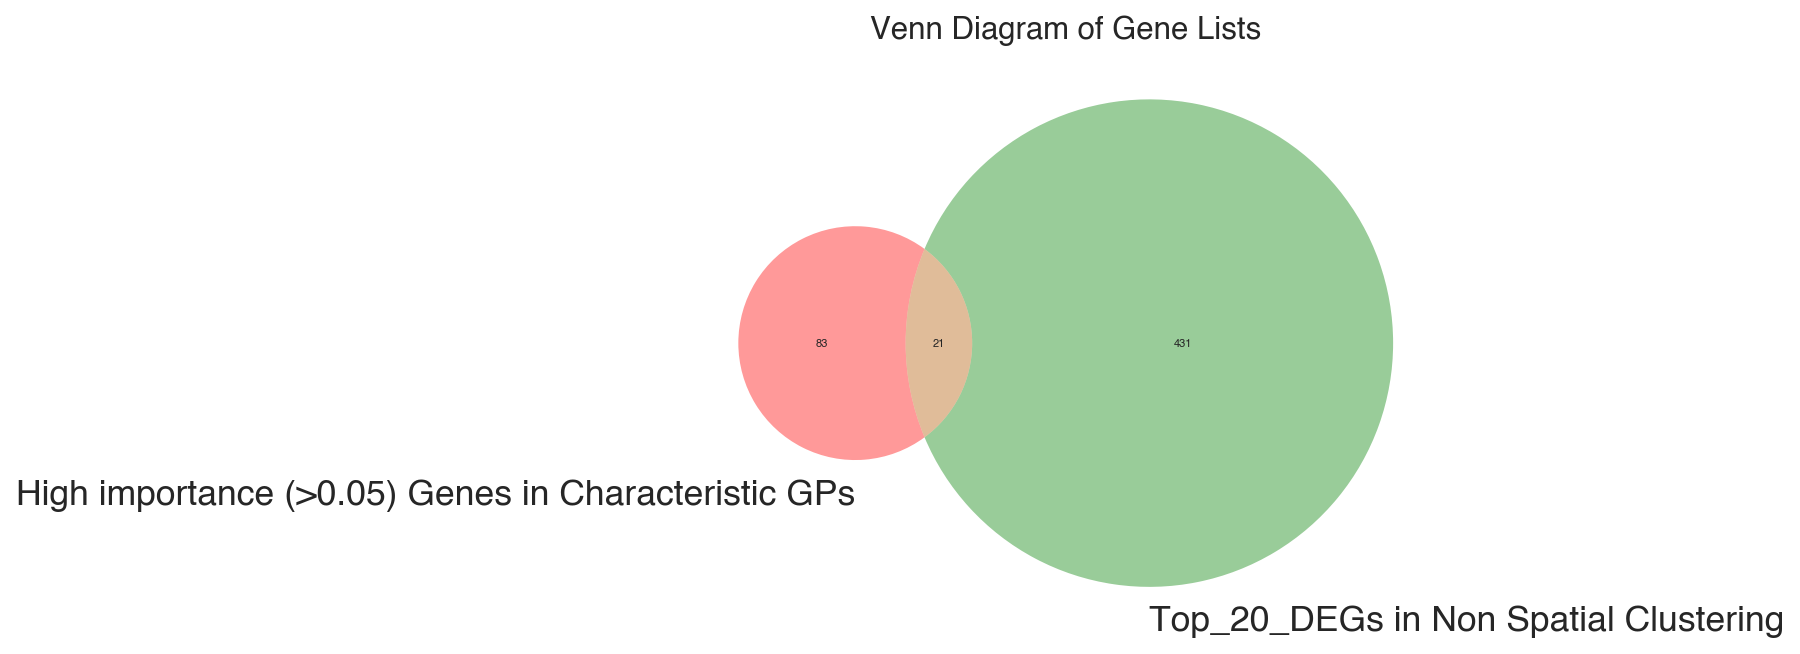

In [49]:
venn = venn2([set1, set2], ('High importance (>0.05) Genes in Characteristic GPs', 'Top_20_DEGs in Non Spatial Clustering'))

plt.title('Venn Diagram of Gene Lists')
# plt.show()
plt.savefig(f'{figure_folder_path}/overlap_20_degs_importance.svg', format='svg', bbox_inches='tight')

### 3.5 Save Results

In [ ]:
if log_norm_omics_features:
    # Log normalize counts for cellxgene server
    sc.pp.normalize_total(model.adata, target_sum=1e4)
    sc.pp.log1p(model.adata)

In [ ]:
# Store gp summary in adata
gp_summary = model.get_gp_summary()
for col in gp_summary.columns:
    gp_summary[col] = gp_summary[col].astype(str)
model.adata.uns["nichecompass_gp_summary"] = gp_summary

In [ ]:
model.adata.write(f"{result_folder_path}/{dataset}_analysis.h5ad")